In [2]:
def download(path):
    import os
    from six.moves import urllib

    fname = path.split('/')[-1]
    if os.path.exists(fname):
        return fname

    print('Downloading ' + path)

    def progress(count, block_size, total_size):
        if count % 20 == 0:
            print('Downloaded %02.02f/%02.02f MB' % (
                count * block_size / 1024.0 / 1024.0,
                total_size / 1024.0 / 1024.0), end='\r')

    filepath, _ = urllib.request.urlretrieve(
        path, filename=fname, reporthook=progress)
    return filepath

In [10]:
import tensorflow as tf
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize

def get_vgg_model():
    download('https://s3.amazonaws.com/cadl/models/vgg16.tfmodel')
    with open("vgg16.tfmodel", mode='rb') as f:
        graph_def = tf.GraphDef()
        try:
            graph_def.ParseFromString(f.read())
        except:
            print('try adding PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python ' +
                  'to environment.  e.g.:\n' +
                  'PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python ipython\n' +
                  'See here for info: ' +
                  'https://github.com/tensorflow/tensorflow/issues/582')

    download('https://s3.amazonaws.com/cadl/models/synset.txt')
    with open('synset.txt') as f:
        labels = [(idx, l.strip()) for idx, l in enumerate(f.readlines())]

    return {
        'graph_def': graph_def,
        'labels': labels,
        'preprocess': preprocess,
        'deprocess': deprocess
    }


def preprocess(img, crop=True, resize=True, dsize=(224, 224)):
    if img.dtype == np.uint8:
        img = img / 255.0

    if crop:
        short_edge = min(img.shape[:2])
        yy = int((img.shape[0] - short_edge) / 2)
        xx = int((img.shape[1] - short_edge) / 2)
        crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    else:
        crop_img = img

    if resize:
        norm_img = imresize(crop_img, dsize)
    else:
        norm_img = crop_img

    return (norm_img).astype(np.float32)


def deprocess(img):
    return np.clip(img * 255, 0, 255).astype(np.uint8)

In [4]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
from scipy.misc import imresize
from scipy.ndimage.filters import gaussian_filter
import IPython.display as ipyd
import tensorflow as tf
%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [5]:
net = get_vgg_model()

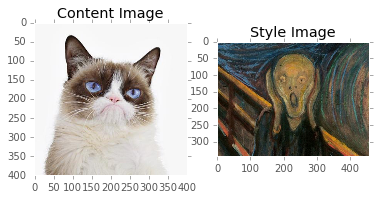

In [11]:
content_og = plt.imread('content1.jpg')[..., :3]
style_og = plt.imread('style1.jpg')[..., :3]
fig, axs = plt.subplots(1, 2)
axs[0].imshow(content_og)
axs[0].set_title('Content Image')
axs[0].grid('off')
axs[1].imshow(style_og)
axs[1].set_title('Style Image')
axs[1].grid('off')
content_img = preprocess(content_og)[np.newaxis]
style_img = preprocess(style_og)[np.newaxis]

plt.imsave(arr=content_og, fname='content.png')
plt.imsave(arr=style_og, fname='style.png')

In [16]:
tf.reset_default_graph()
g = tf.Graph()

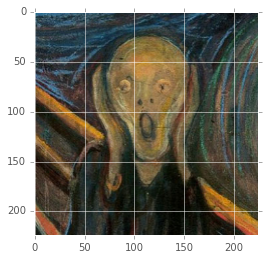

In [15]:
plt.imshow(deprocess(preprocess(style_og)))

In [17]:
with tf.Session(graph=g) as sess:
    tf.import_graph_def(net['graph_def'], name='net')
    names = [op.name for op in g.get_operations()]
    x = g.get_tensor_by_name(names[0] + ':0')
    softmax = g.get_tensor_by_name(names[-2] + ':0')

In [18]:
with tf.Session(graph=g) as sess:
    content_layer = 'net/conv4_2/conv4_2:0'
    content_features = g.get_tensor_by_name(content_layer).eval(
            session=sess,
            feed_dict={x: content_img,
                'net/dropout_1/random_uniform:0': [[1.0]],
                'net/dropout/random_uniform:0': [[1.0]]
            })
print(content_features.shape)

(1, 28, 28, 512)


In [19]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):    
    res = softmax.eval(feed_dict={x: content_img})[0]
    print([(res[idx], net['labels'][idx])
           for idx in res.argsort()[-5:][::-1]])

[(0.34401542, (284, 'n02123597 Siamese cat, Siamese')), (0.23307902, (281, 'n02123045 tabby, tabby cat')), (0.095559426, (287, 'n02127052 lynx, catamount')), (0.056556646, (463, 'n02909870 bucket, pail')), (0.054414328, (588, 'n03482405 hamper'))]


In [20]:
style_layers = ['net/conv1_1/conv1_1:0',
                'net/conv2_1/conv2_1:0',
                'net/conv3_1/conv3_1:0',
                'net/conv4_1/conv4_1:0',
                'net/conv5_1/conv5_1:0']
style_activations = []

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    for style_i in style_layers:
        style_activation_i = g.get_tensor_by_name(style_i).eval(
            feed_dict={
                x: style_img,
                'net/dropout_1/random_uniform:0': [[1.0]],
                'net/dropout/random_uniform:0': [[1.0]]})
        style_activations.append(style_activation_i)

In [21]:
style_features = []
for style_activation_i in style_activations:
    s_i = np.reshape(style_activation_i, [-1, style_activation_i.shape[-1]])
    gram_matrix = np.matmul(s_i.T, s_i) / s_i.size
    style_features.append(gram_matrix.astype(np.float32))

In [22]:
tf.reset_default_graph()
g = tf.Graph()
net = get_vgg_model()
net = get_vgg_model()
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    net_input = tf.Variable(content_img)
    tf.import_graph_def(
        net['graph_def'],
        name='net',
        input_map={'images:0': net_input})

In [23]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_loss = tf.nn.l2_loss((g.get_tensor_by_name(content_layer) -
                                 content_features) /
                                 content_features.size)

In [24]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    style_loss = np.float32(0.0)
    for style_layer_i, style_gram_i in zip(style_layers, style_features):
        layer_i = g.get_tensor_by_name(style_layer_i)
        layer_shape = layer_i.get_shape().as_list()
        layer_size = layer_shape[1] * layer_shape[2] * layer_shape[3]
        layer_flat = tf.reshape(layer_i, [-1, layer_shape[3]])
        gram_matrix = tf.matmul(tf.transpose(layer_flat), layer_flat) / layer_size
        style_loss = tf.add(style_loss, tf.nn.l2_loss((gram_matrix - style_gram_i) / np.float32(style_gram_i.size)))

In [25]:
def total_variation_loss(x):
    h, w = x.get_shape().as_list()[1], x.get_shape().as_list()[1]
    dx = tf.square(x[:, :h-1, :w-1, :] - x[:, :h-1, 1:, :])
    dy = tf.square(x[:, :h-1, :w-1, :] - x[:, 1:, :w-1, :])
    return tf.reduce_sum(tf.pow(dx + dy, 1.25))

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    tv_loss = total_variation_loss(net_input)

In [26]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    loss = 0.1 * content_loss + 5.0 * style_loss + 0.01 * tv_loss
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

0: 13.268818, (0.012291 - 1.009982)


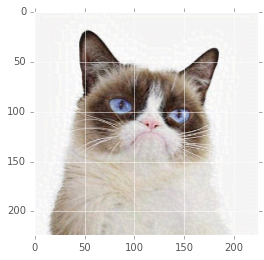

1: 11.783970, (0.022269 - 1.018655)
2: 10.708842, (0.032207 - 1.026390)
3: 9.846779, (0.025122 - 1.034762)
4: 9.117258, (0.016953 - 1.044145)
5: 8.488930, (0.007024 - 1.052204)


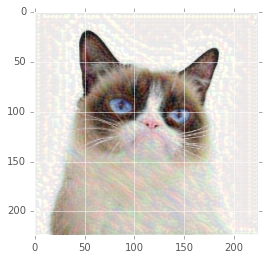

6: 7.946287, (-0.002903 - 1.058903)


In [ ]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    sess.run(tf.initialize_all_variables())
    n_iterations = 50
    og_img = net_input.eval()
    imgs = []
    for it_i in range(n_iterations):
        _, this_loss, synth = sess.run([optimizer, loss, net_input],
                feed_dict={
                    'net/dropout_1/random_uniform:0':
                        np.ones(g.get_tensor_by_name(
                        'net/dropout_1/random_uniform:0').get_shape().as_list()),
                    'net/dropout/random_uniform:0':
                        np.ones(g.get_tensor_by_name(
                        'net/dropout/random_uniform:0').get_shape().as_list())})
        print("%d: %f, (%f - %f)" %
            (it_i, this_loss, np.min(synth), np.max(synth)))
        if it_i % 5 == 0:
            m = deprocess(synth[0])
            imgs.append(m)
            plt.imshow(m)
            plt.show()